## HEART SOUND ANALYSIS AND CLASSIFICATION 

### 1. Introducción

Antes de empezar con el análisis y la clasificación de los distintos sonidos, se procede a explicar en qué consiste el análisis y cómo son los datos de los que se dispone.

Los sonidos del corazón son muy característicos del propio individuo y son generados por los latidos del corazón y el flujo de sangre a través de él. En los adultos sanos, hay dos sonidos cardíacos normales, comúnmente descritos como __lub__ y __dub__ (o dup). Estas onomatopeyas habituales constituyen los dos sonidos característicos de un corazón sano siendo __lub__ el primer sonido cardíaco __(S1)__ y __dub__ (o dup) el segundo sonido cardíaco __(S2)__. Ambos ocurren en secuencia con cada latido del corazón y se producen por el cierre de válvulas auriculoventriculares y semilunares, respectivamente.


### 2. Contenido 

Los datos de los que se dispone se dividen en dos conjuntos de datos diferentes, el __set A__ y el __set B__. Además de los audios correspondientes, se dispone también de varios ficheros __.csv__ que nos proporcionan diferente información:

    - set_a.csv : contiene etiquetas y metadatos de latidos del corazón recopilados del público en general a través de una aplicación para iPhone.

    - set_a_timing.csv : contiene información de tiempo estándar para las grabaciones "normales" del conjunto A.

    - set_b.csv : contiene etiquetas y metadatos de latidos cardíacos recopilados en un ensayo clínico en hospitales con un estetoscopio digital.

    - archivos de audio : diferentes longitudes de audios que van desde 1 a 30 segundos. En algunos casos, los archivos se han recortado para reducir el ruido excesivo de los mismos y proporcionar así el frangmentos saliente del sonido. 


### 3.1 Exploración de los datos

En primer lugar, se procede a analizar los datos del directorio __archive__ tanto en contenido como en organización:

In [1]:
import warnings   
import IPython.display as ipd
warnings.filterwarnings("ignore")
%matplotlib inline
%pylab inline
import os
import pandas as pd
import librosa
import librosa.display
import glob 
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Carga de los datos correspondientes al conjunto A
set_a=pd.read_csv('./archive/set_a.csv')
print(set_a.label.unique())
set_a.head()


['artifact' 'extrahls' 'murmur' 'normal' nan]


,dataset,fname,label,sublabel
0,a,set_a/artifact__201012172012.wav,artifact,NaN
1,a,set_a/artifact__201105040918.wav,artifact,NaN
2,a,set_a/artifact__201105041959.wav,artifact,NaN
3,a,set_a/artifact__201105051017.wav,artifact,NaN
4,a,set_a/artifact__201105060108.wav,artifact,NaN


In [3]:
# Carga de los datos correspondientes al conjunto B
set_b=pd.read_csv('./archive/set_b.csv')
print(set_b.label.unique())
set_b.head()

['extrastole' 'murmur' 'normal' nan]


,dataset,fname,label,sublabel
0,b,set_b/Btraining_extrastole_127_1306764300147_C...,extrastole,NaN
1,b,set_b/Btraining_extrastole_128_1306344005749_A...,extrastole,NaN
2,b,set_b/Btraining_extrastole_130_1306347376079_D...,extrastole,NaN
3,b,set_b/Btraining_extrastole_134_1306428161797_C...,extrastole,NaN
4,b,set_b/Btraining_extrastole_138_1306762146980_B...,extrastole,NaN


Con el fin de poder tener todos los datos en un mismo conjunto de datos, se unen ambos datasets para así trabajar de una forma más cómoda y rápida. De esta manera, se dispondrá de todos los labels en un mismo dataframe pues, como se puede ver en los resultados anteriores, para los audios grabados con la aplicación de iPhone __(setA)__ existen *_5 clases diferentes_* mientras que, para el caso del __setB__ se dispone de *_4 clases distintas_*.

In [4]:
datasets = [set_a, set_b]
train_dataset=pd.concat(datasets)
print("Número de classes: {}".format(len(train_dataset.label.unique())))
print("Clases: {}".format(train_dataset.label.unique()))
print("Número de observaciones/audios: {}".format(len(train_dataset)))
train_dataset.head()

Number of classes: 6
Classes: ['artifact' 'extrahls' 'murmur' 'normal' nan 'extrastole']
Number of observations/audios: 832


,dataset,fname,label,sublabel
0,a,set_a/artifact__201012172012.wav,artifact,NaN
1,a,set_a/artifact__201105040918.wav,artifact,NaN
2,a,set_a/artifact__201105041959.wav,artifact,NaN
3,a,set_a/artifact__201105051017.wav,artifact,NaN
4,a,set_a/artifact__201105060108.wav,artifact,NaN


Como se puede ver en el ouput de la celda anterior, el nuevo dataset creado tiene la misma forma que los sets A y B con la única diferencia de que ahora se dispone de todos los datos en un mismo dataframe. A partir de los datos de los que se dispone, interesa saber cómo estan distribuidos los mismos, es decir, cuántos audios hay para cada categoría de sonidos __(extrahls,artifact,extrastole,murmur,normal)__.

Además, es interesante ver cómo estan distribuidos los datos, es decir, de cuántos audios se dispone para cada label para así tener una idea de la cantidad de los datos que se van a usar.

Min nº de muestras por categoría =  19
Max nº de muestras por categoría =  351


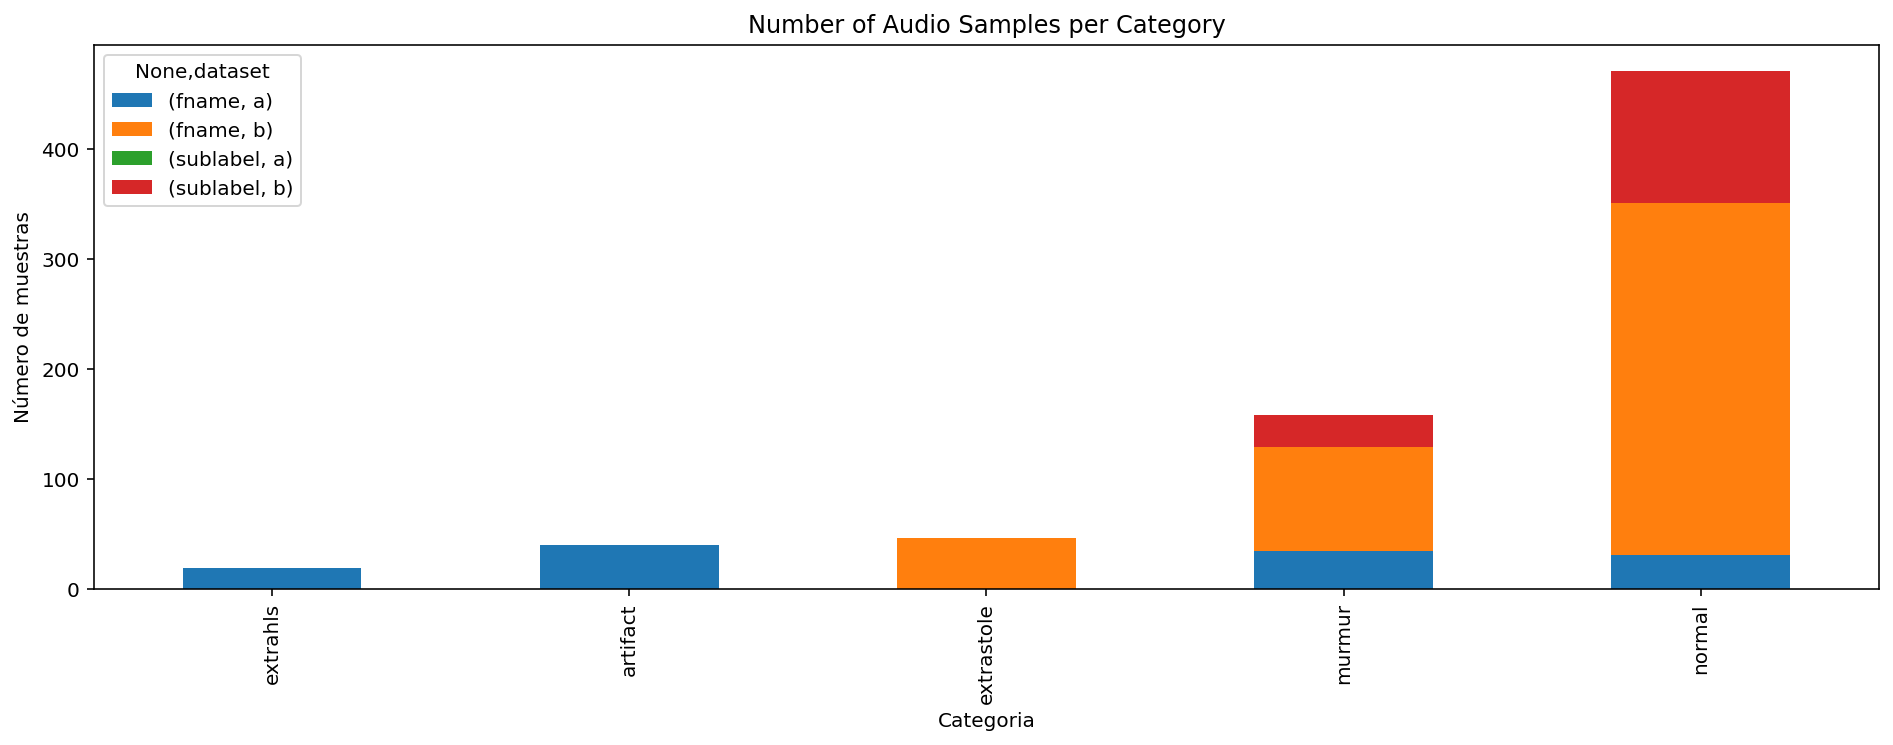

In [27]:
category_group = train_dataset.groupby(['label','dataset']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index).plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,5))
plot.set_xlabel("Categoria")
plot.set_ylabel("Número de muestras")

print('Min nº de muestras por categoría = ', min(train_dataset.label.value_counts()))
print('Max nº de muestras por categoría = ', max(train_dataset.label.value_counts()))

A partir del gráfico anterior, se puede concluir que de la categoría __extrahls__ se tienen pocos audios, en concreto un total de __19 audios__ pues esta categoria se corresponde a la catgoría con minímo número de muestras. Por el contrario, para el caso de los audios de la categoría __normal__ se dispone de __351 muestras__ conformado así la categoría con un mayor número de muestras.

A continuación, se dispone a analizar cada una de las categorías de sonidos para identificar cómo se escuchan y, además, se muestran los gráficos de onda de cada uno de ellos. Las distintas categorías a analizar son las siguientes: 

    - Normal
    - Murmur
    - Extrasístole
    - Artefacto
    - Sonido extra del corazón

### 3.1.1 Categoría normal

Esta categoría se encuentran los sonidos normales de un corazón sano. Puede haber ruido en el último segundo de cada uno de ellos puesto que el dispositivo es alejado en ese mismo momento del cuerpo así como ruidos de fondo (desde tráfico hasta radios). Por otro lado, también pueden existir ruidos procedentes de la propia respiración del individuo o de rozar el micrófono con la ropa o la piel. Un sonido normal del corazón (con una frecuencia cardíaca de menos de 140 latidos por minuto) tiene un patrón __lub dub, lub dub__ claro con un tiempo de __lub__ a __dub__ menor que de __dub__ al próximo __lub__

In [35]:
audio_normal = 'archive/set_a/normal__201106111136.wav'
ipd.Audio(audio_normal)

In [75]:
y_normal, sr = librosa.load(audio_normal)   
print('El sampling rate por defecto es: {}'.format(sr))
dur=librosa.get_duration(y_normal)
print ('La duración del audio es: {}'.format(dur))
print('El tamaño de y (con las amplitudes correspondientes de la onda en t) es: {}'.format(y_normal.shape))

El sampling rate por defecto es: 22050
La duración del audio es: 7.935555555555555
El tamaño de y (con las amplitudes correspondientes de la onda en t) es: (174979,)


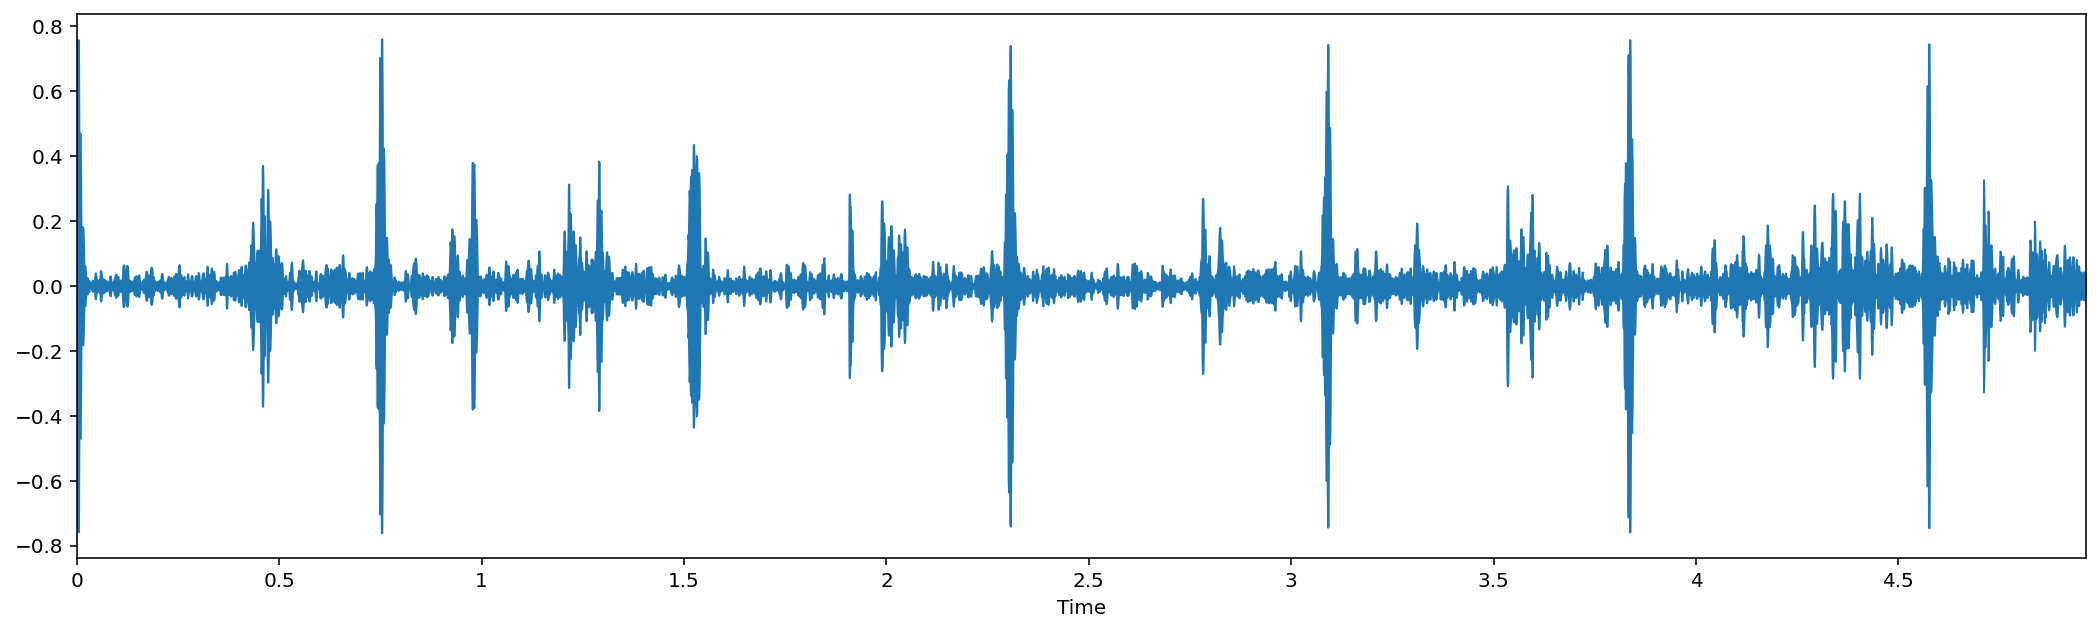

In [34]:
plt.figure(figsize=(18, 5))
librosa.display.waveplot(y_normal, sr=sr)

[]

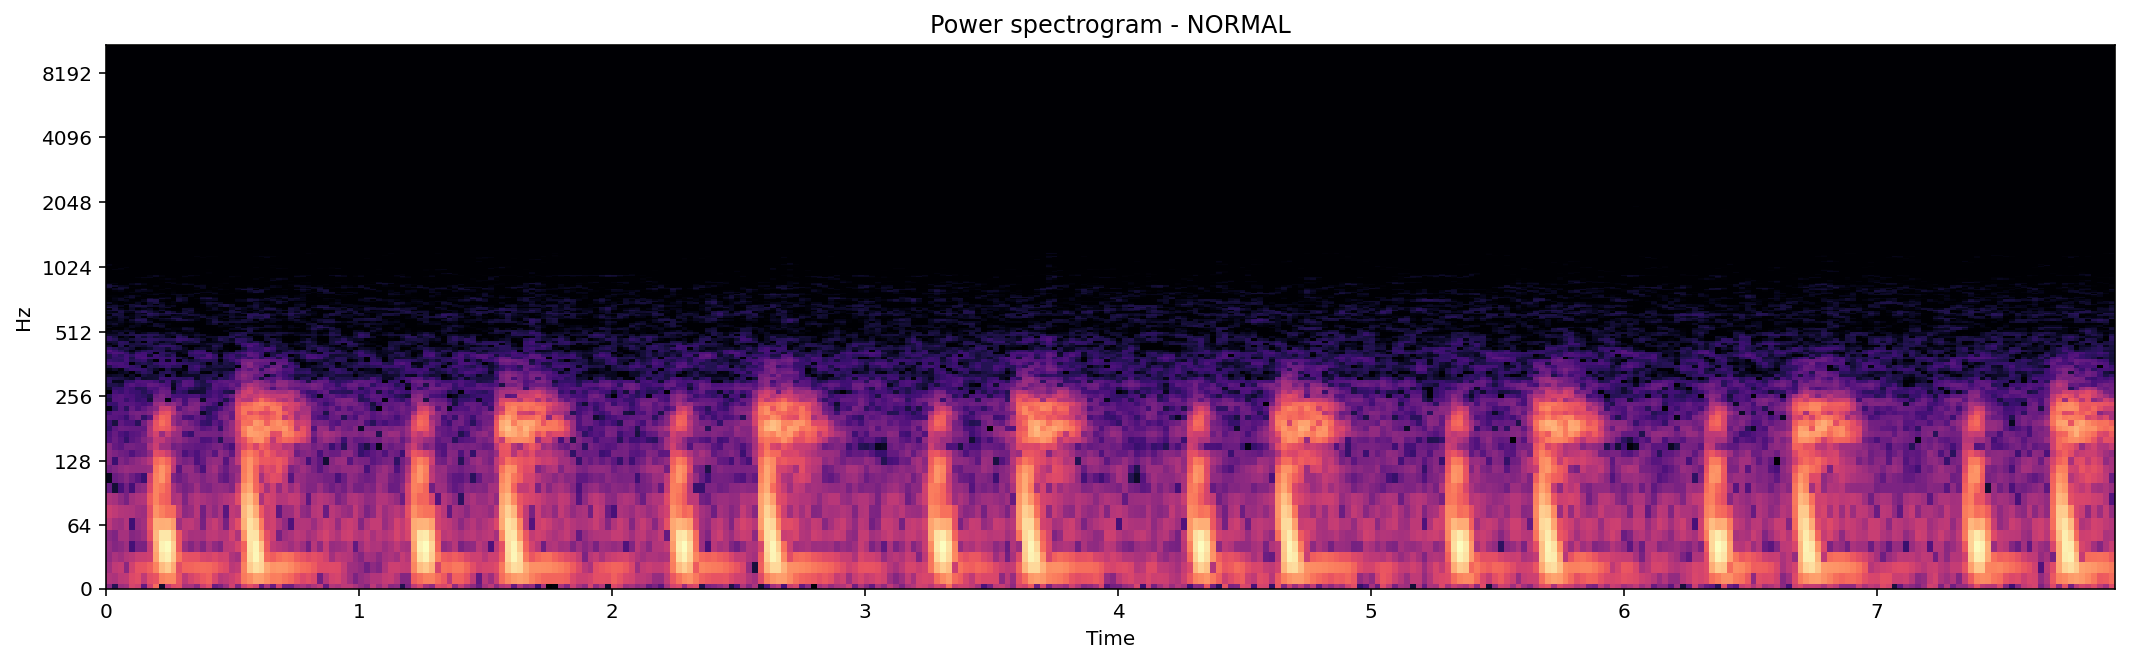

In [79]:
spect_normal = np.abs(librosa.stft(y_normal))
plt.figure(figsize=(18, 5))
img=librosa.display.specshow(librosa.amplitude_to_db(spect_normal, ref=np.max),x_axis='time', y_axis='log')
fig.colorbar(img)
plt.title('Power spectrogram - NORMAL')
plt.plot()

### 3.1.2 Categoría Murmur

Los soplos cardíacos suenan como si hubiera un __silbido__ o __fluido turbulento__ en una de dos ubicaciones temporales: 

   - Entre __lub__ y __dub__.
   - Entre __dub__ y __lub__.
   
Este tipo de sonidos pueden ser síntoma de muchos trastornos cardíacos, algunos muy graves. Sin embargo, el __lub__ __dub__ seguirá siendo parte del sonido aunque estará distorcionado por el _*flujo*_ anteriormente mencionado.

In [47]:
murmur = 'archive/set_a/murmur__201108222231.wav'
ipd.Audio(murmur)

In [48]:
y_murmur, sr = librosa.load(murmur)   
print('El sampling rate por defecto es: {}'.format(sr))
dur=librosa.get_duration(y_murmur)
print ('La duración del audio es: {}'.format(dur))
print('El tamaño de y (con las amplitudes correspondientes de la onda en t) es: {}'.format(y_murmur.shape))

El sampling rate por defecto es: 22050
La duración del audio es: 7.935555555555555
El tamaño de y (con las amplitudes correspondientes de la onda en t) es: (174979,)


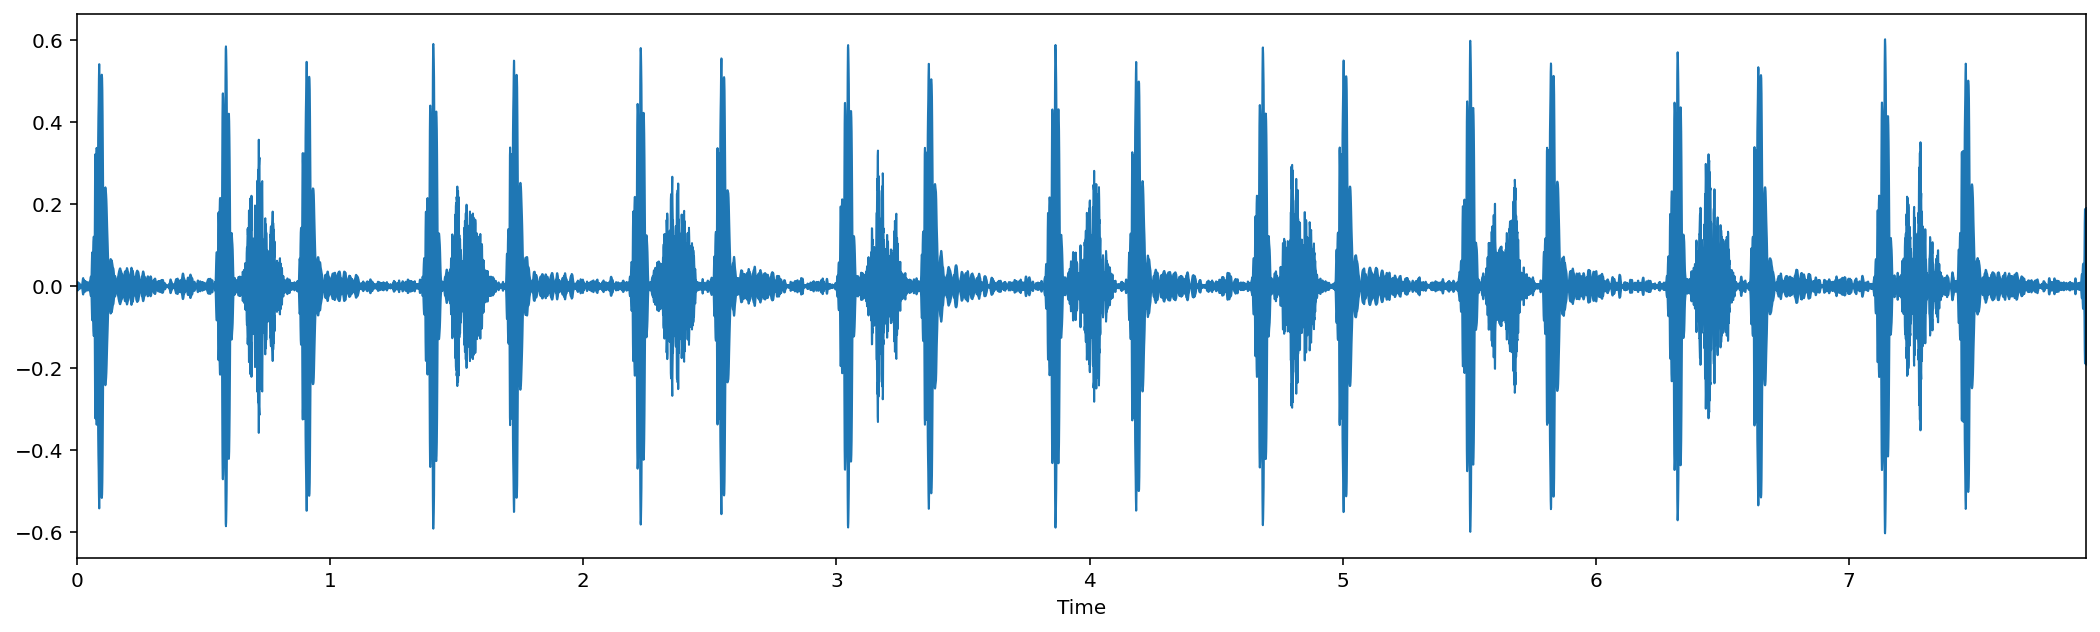

In [71]:
plt.figure(figsize=(18, 5))
librosa.display.waveplot(y_murmur, sr=sr)

[]

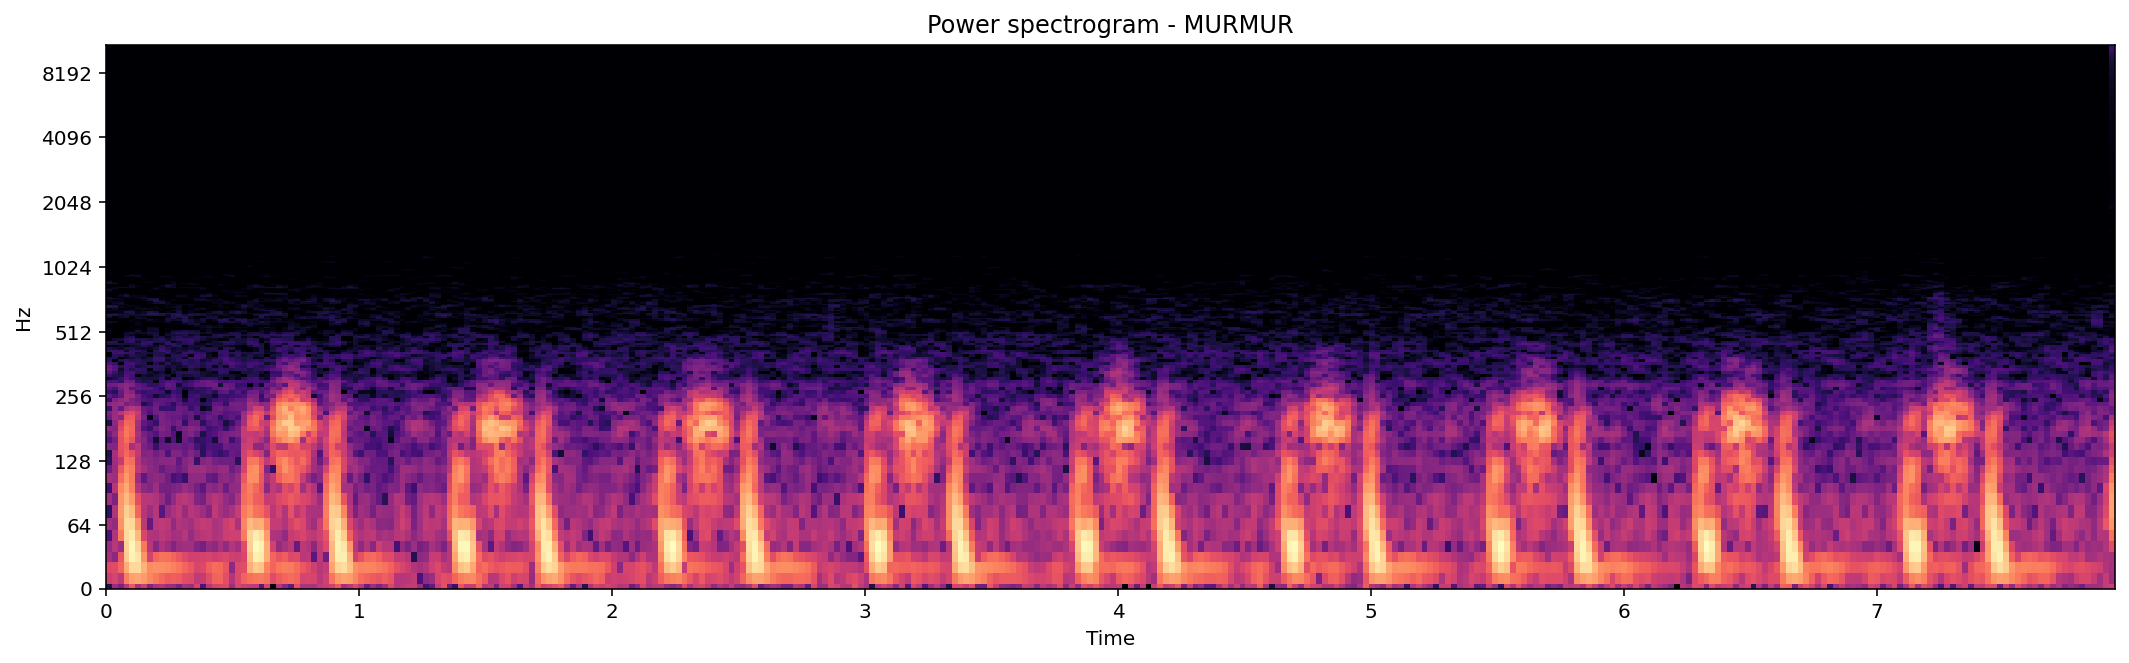

In [72]:
spect_murmur = np.abs(librosa.stft(y_murmur))
plt.figure(figsize=(18, 5))
librosa.display.specshow(librosa.amplitude_to_db(spect_murmur, ref=np.max),x_axis='time', y_axis='log')
plt.title('Power spectrogram - MURMUR')
plt.plot()

### 3.1.3 Categoría Extrasístole

Los sonidos de extrasístole pueden aparecer ocasionalmente y pueden identificarse porque hay un ruido cardíaco que está fuera de ritmo y que implica latidos cardíacos adicionales o saltados. Por ejemplo, podría darse el caso de que el sonido siguiera el siguiente patrón: __lub-lub dub__ o un __lub dub-dub__. Esto no es lo mismo que un ruido cardíaco adicional puesto que el evento no ocurre con regularidad. Una extrasístole puede no ser un signo de enfermedad. Es muy común en niños y suele ocurrir de manera normal en adultos. Sin embargo, si es verdad que en algunas situaciones las extrasístoles pueden ser causadas por enfermedades cardíacas.Si estas enfermedades se detectan antes, es probable que el tratamiento sea más eficaz.

In [55]:
extrasystole = 'archive/set_b/extrastole__210_1308162935880_C.wav'
ipd.Audio(extrasystole)

In [58]:
y_extrasystole, sr = librosa.load(extrasystole,duration=5)   
print('El sampling rate por defecto es: {}'.format(sr))
dur=librosa.get_duration(y_extrasystole)
print ('La duración del audio es: {}'.format(dur))
print('El tamaño de y (con las amplitudes correspondientes de la onda en t) es: {}'.format(y_extrasystole.shape))

El sampling rate por defecto es: 22050
La duración del audio es: 5.0
El tamaño de y (con las amplitudes correspondientes de la onda en t) es: (110250,)


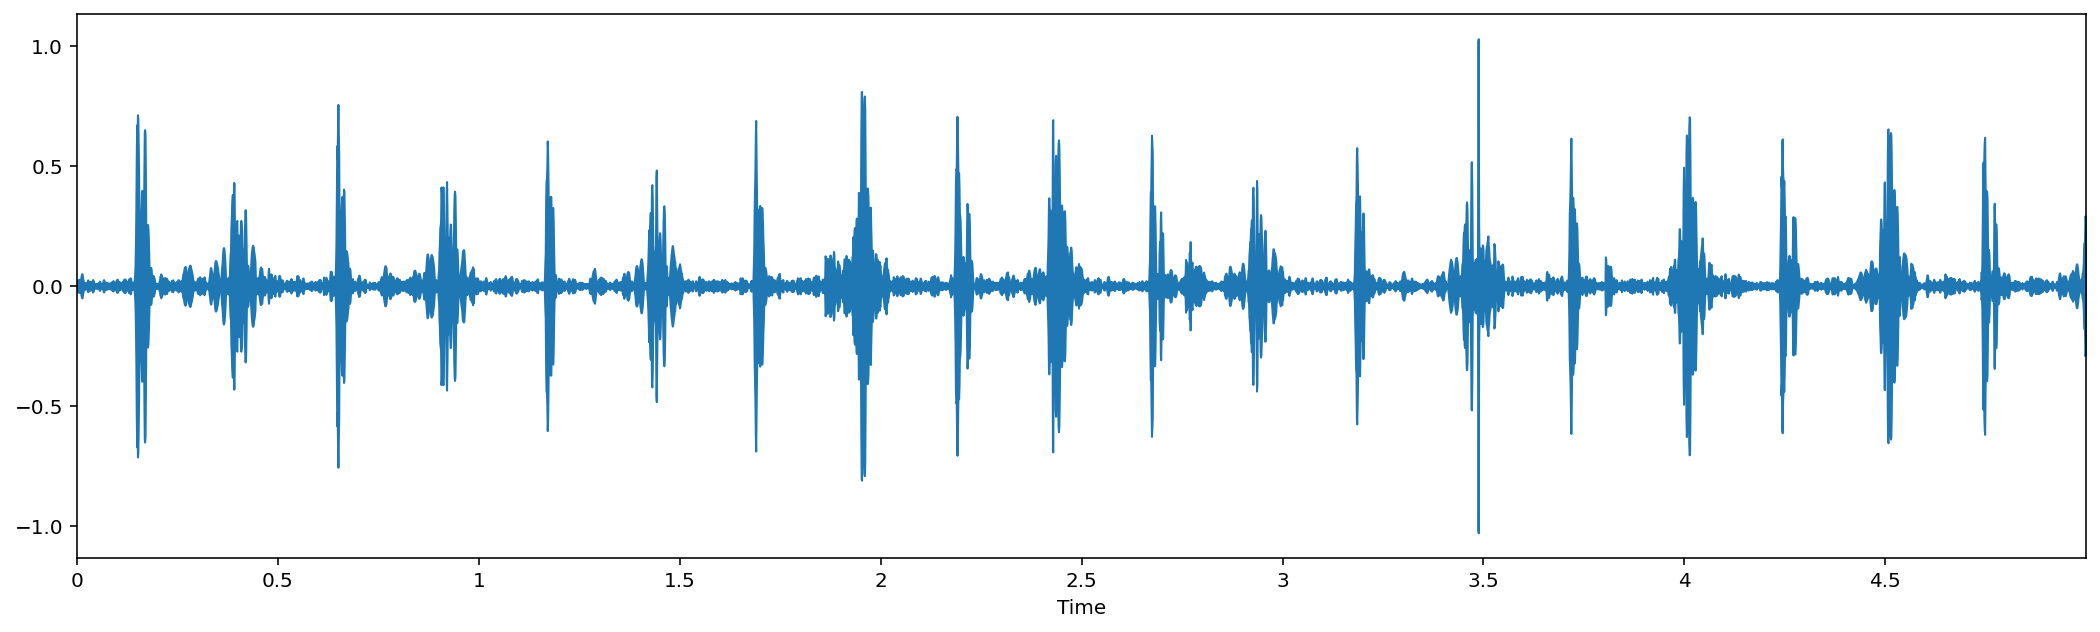

In [59]:
plt.figure(figsize=(18, 5))
librosa.display.waveplot(y_extrasystole, sr=sr)

[]

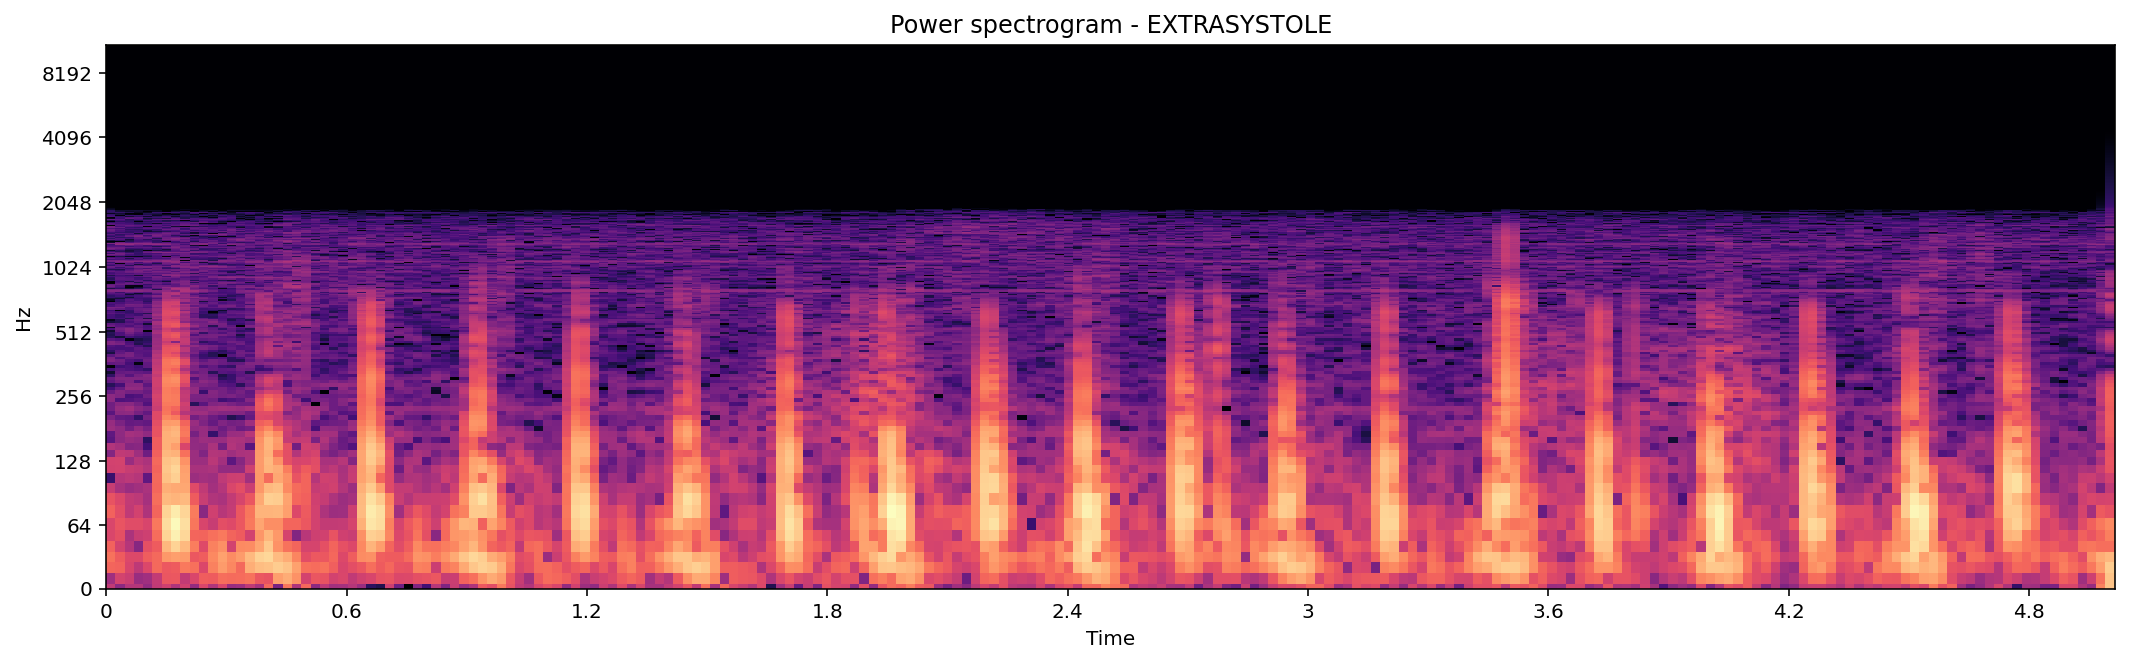

In [73]:
spect_extrasystole = np.abs(librosa.stft(y_extrasystole))
plt.figure(figsize=(18, 5))
librosa.display.specshow(librosa.amplitude_to_db(spect_extrasystole, ref=np.max),x_axis='time', y_axis='log')
plt.title('Power spectrogram - EXTRASYSTOLE')
plt.plot()